In [46]:
from pomegranate import BayesianNetwork, DiscreteDistribution, ConditionalProbabilityTable, Node, State
import matplotlib.pyplot as plt
from pprint import pprint
from copy import deepcopy
from itertools import product
import numpy as np
import pandas as pd
from IPython.display import display

In [51]:
def generate_CPT(event, dependencies, debug=False):
    deps = deepcopy(dependencies)
        
    for dep in deps:
        if len(dep) < 2:
            dep[0] = [pr for st, pr in event.items()]
            
    e_states = list(event.keys())
    d_states = [list(dep.keys()) for dep in deps]
    
    table = list(list(i) for i in product(*d_states, e_states))
    
    for row in table:
        e_state = row[-1]
        s_i = e_states.index(e_state)
        formula = []

        for i, state in enumerate(row[:-1]):
            formula.append(deps[i][state][s_i])
        
        formula = 1 - np.prod(1 - np.array(formula))
        row.append(formula)
    
    states = len(e_states)
    sums = np.array(table)[:,-1].reshape(-1,states).astype(np.float).sum(axis=1)
    
    for i, row in enumerate(table):
        row[-1] = row[-1] / sums[int(i / states)]
        row[-1] = round(row[-1], 3)
    if debug:
        display(pd.DataFrame(table).T)
    return table

# Априорные вероятности

In [52]:
e_smoking = {
    1: 0.5,
    0: 0.5,
}

e_ater = {
    1: 0.1,
    0: 0.9,
}

e_imt = {
    1: 0.3,
    0: 0.7,
}

e_age_mt_40 = {
    1: 0.5,
    0: 0.5,
}

e_stress = {
    1: 0.2,
    0: 0.8,
}

e_prev_ha = {
    1: 0.01,
    0: 0.99,
}

e_ha = {
    1: 0.01,
    0: 0.99,
}

e_sten = {
    1: 0.01,
    0: 0.99,
}

e_nevralgia = {
    1: 0.05,
    0: 0.95,
}

e_chest_pain = {
    1: 0.01,
    0: 0.99,
}

e_pain_mt_15min = {
    1: 0.01,
    0: 0.99,
}

e_dyspnea = {
    1: 0.01,
    0: 0.99,
}

# Апостериорные вероятности

In [53]:
d_smoke_ater = {1: [0.9, 0.1]}
d_imt_ater = {1: [0.8, 0.2]}
d_age_mt_40_ater = {1: [0.7, 0.3]}

d_prev_ha_ha = {1: [0.5, 0.5]}
d_stress_ha = {1: [0.8, 0.2]}
d_ater_ha = {1: [0.99, 0.01]}
d_age_mt_40_ha = {1: [0.85, 0.15]}

d_stress_sten = {1: [0.8, 0.2]}
d_ater_sten = {1: [0.99, 0.01]}
d_age_mt_40_sten = {1: [0.65, 0.35]}

d_imt_nevralgia = {1: [0.05, 0.95], 0: [0.9, 0.1]}
d_age_mt_40_nevralgia = {1: [0.1, 0.9], 0: [0.9, 0.1]}

d_nevralgia_chest_pain = {1: [0.99, 0.01]}
d_sten_chest_pain = {1: [0.99, 0.01]}
d_ha_chest_pain = {1: [0.99, 0.01]}

d_nevralgia_pain_mt_15min = {1: [0.01, 0.99]}
d_sten_pain_mt_15min = {1: [0.01, 0.99]}
d_ha_pain_mt_15min = {1: [0.99, 0.01]}

d_sten_dyspnea = {1: [0.99, 0.01]}
d_ha_dyspnea = {1: [0.01, 0.99]}

In [54]:
# Курение
smoking = DiscreteDistribution(e_smoking)

# ИМТ (худой, полный)
imt = DiscreteDistribution(e_imt)

# Старше 40 лет
age_mt_40 = DiscreteDistribution(e_age_mt_40)

# Атеросклероз
ater = ConditionalProbabilityTable(
    generate_CPT(e_ater, 
                 [d_smoke_ater, d_imt_ater, d_age_mt_40_ater], debug=True),
    [smoking, imt, age_mt_40]
)

# Стресс
stress = DiscreteDistribution(e_stress)

# Инфаркт в анамнезе
prev_ha = DiscreteDistribution(e_prev_ha)

# Инфаркт
ha = ConditionalProbabilityTable(
    generate_CPT(e_ha, 
                 [d_prev_ha_ha, d_stress_ha, d_ater_ha, d_age_mt_40_ha]),
    [prev_ha, stress, ater, age_mt_40]
)

# Стенокардия
sten = ConditionalProbabilityTable(
    generate_CPT(e_sten, 
                 [d_stress_sten, d_ater_sten, d_age_mt_40_sten]),
    [stress, ater, age_mt_40]
)

# Межреберная невралгия
nevralgia = ConditionalProbabilityTable(
    generate_CPT(e_nevralgia, 
                 [d_imt_nevralgia, d_age_mt_40_nevralgia]),
    [imt, age_mt_40]
)

# Загрудинные боли
chest_pain = ConditionalProbabilityTable(
    generate_CPT(e_chest_pain, 
                 [d_imt_nevralgia, d_sten_chest_pain, d_ha_chest_pain]),
    [nevralgia, sten, ha]
)

# Боли > 15 мин
pain_mt_15min = ConditionalProbabilityTable(
    generate_CPT(e_pain_mt_15min, 
                 [d_nevralgia_pain_mt_15min, d_sten_pain_mt_15min, d_ha_pain_mt_15min]),
    [nevralgia, sten, ha]
)

# Одышка
dyspnea = ConditionalProbabilityTable(
    generate_CPT(e_dyspnea, 
                 [d_sten_dyspnea, d_ha_dyspnea]),
    [sten, ha]
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000
2,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000
3,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000
4,0.667,0.333,0.514,0.486,0.509,0.491,0.481,0.519,0.501,0.499,0.458,0.542,0.433,0.567,0.213,0.787


In [32]:
n_smoking = State(smoking, name='курение')
n_imt = State(imt, name='имт')
n_age_mt_40 = State(age_mt_40, name='старше 40')
n_ater = State(ater, name='атеросклероз')
n_stress = State(stress, name='стресс')
n_prev_ha = State(prev_ha, name='инфаркт в анамнезе')
n_ha = State(ha, name='инфаркт')
n_sten = State(sten, name='стенокардия')
n_nevralgia = State(nevralgia, name='невралгия')
n_chest_pain = State(chest_pain, name='загрудинные боли')
n_pain_mt_15min = State(pain_mt_15min, name='боли > 15 мин')
n_dyspnea = State(dyspnea, name='одышка')

In [33]:
# n_smoking = State(smoking, name='smoking')
# n_imt = State(imt, name='imt')
# n_age_mt_40 = State(age_mt_40, name='age_mt_40')
# n_ater = State(ater, name='ater')
# n_stress = State(stress, name='stress')
# n_prev_ha = State(prev_ha, name='prev_ha')
# n_ha = State(ha, name='ha')
# n_sten = State(sten, name='sten')
# n_nevralgia = State(nevralgia, name='nevralgia')
# n_chest_pain = State(chest_pain, name='chest_pain')
# n_pain_mt_15min = State(pain_mt_15min, name='pain_mt_15min')
# n_dyspnea = State(dyspnea, name='dyspnea')

In [11]:
model = BayesianNetwork('Этиологически-ориентированная СППВР')

model.add_states(n_smoking, n_imt, n_age_mt_40, n_ater, n_stress, n_prev_ha, 
                 n_ha, n_sten, n_nevralgia, n_chest_pain, n_pain_mt_15min, n_dyspnea)

In [12]:
# model.add_edge(n_smoking, n_ha)
# model.add_edge(n_smoking, n_sten)
model.add_edge(n_smoking, n_ater)

model.add_edge(n_imt, n_ater)
model.add_edge(n_imt, n_nevralgia)

model.add_edge(n_ater, n_sten)
model.add_edge(n_ater, n_ha)

model.add_edge(n_age_mt_40, n_ater)
model.add_edge(n_age_mt_40, n_nevralgia)
model.add_edge(n_age_mt_40, n_sten)
model.add_edge(n_age_mt_40, n_ha)

model.add_edge(n_stress, n_ha)
model.add_edge(n_stress, n_sten)

model.add_edge(n_prev_ha, n_ha)

model.add_edge(n_nevralgia, n_chest_pain)
model.add_edge(n_nevralgia, n_pain_mt_15min)

model.add_edge(n_sten, n_chest_pain)
model.add_edge(n_sten, n_pain_mt_15min)
model.add_edge(n_sten, n_dyspnea)

model.add_edge(n_ha, n_chest_pain)
model.add_edge(n_ha, n_pain_mt_15min)
model.add_edge(n_ha, n_dyspnea)

In [13]:
model.bake()

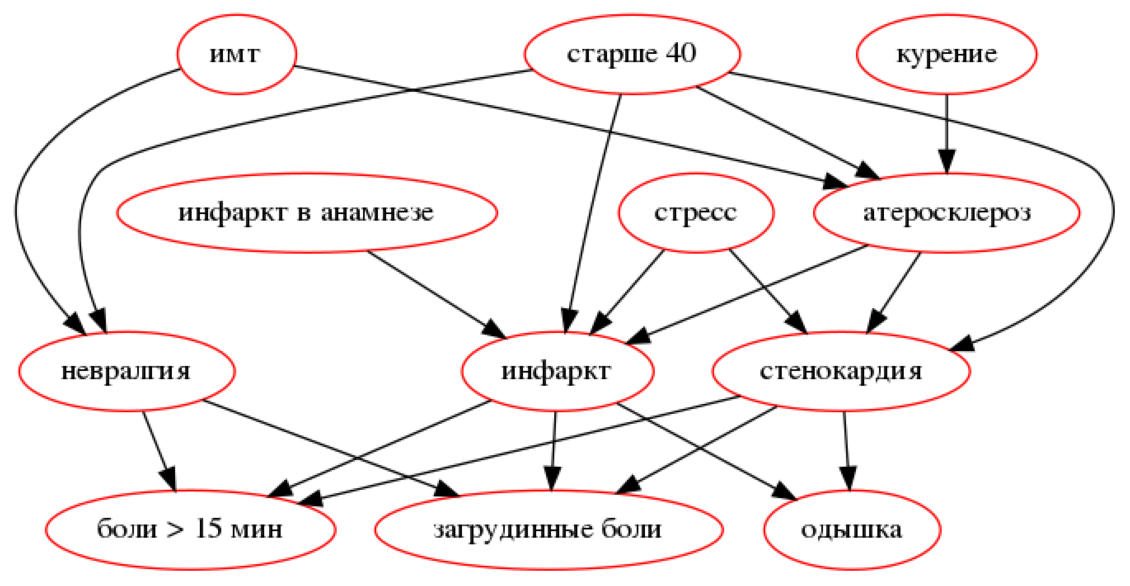

In [14]:
plt.figure(figsize=(20, 20))
model.plot()
plt.show()

In [15]:
def convert_prediction_to_string(model, predictions):
    result = []
    for i, state in enumerate(model.states):
        name = state.name.upper()
        if type(predictions[i]) in [str, int] :
            pred = predictions[i]
        else:
            pred = '\n'.join([f'{key}:  \t{predictions[i].parameters[0][key]:.0%}' for key in predictions[i].parameters[0]])
        result.append(f'{name}:\n{pred}')
    return '\n\n'.join(result)

In [62]:
prediction = model.predict_proba({'курение': 1, 'стресс': 1, 'загрудинные боли': 1,
                                  'боли > 15 мин': 0, 'старше 40': 1, 'инфаркт в анамнезе': 1})
print(convert_prediction_to_string(model, prediction))

КУРЕНИЕ:
1

ИМТ:
1:  	33%
0:  	67%

СТАРШЕ 40:
1

АТЕРОСКЛЕРОЗ:
0:  	43%
1:  	57%

СТРЕСС:
1

ИНФАРКТ В АНАМНЕЗЕ:
1

ИНФАРКТ:
0:  	50%
1:  	50%

СТЕНОКАРДИЯ:
0:  	31%
1:  	69%

НЕВРАЛГИЯ:
0:  	70%
1:  	30%

ЗАГРУДИННЫЕ БОЛИ:
1

БОЛИ > 15 МИН:
0

ОДЫШКА:
0:  	65%
1:  	35%


In [60]:
prediction = model.predict_proba({'курение': 1, 'стресс': 1, 'загрудинные боли': 1,
                                  'боли > 15 мин': 0, 'старше 40': 1})
print(convert_prediction_to_string(model, prediction))

КУРЕНИЕ:
1

ИМТ:
1:  	33%
0:  	67%

СТАРШЕ 40:
1

АТЕРОСКЛЕРОЗ:
0:  	42%
1:  	58%

СТРЕСС:
1

ИНФАРКТ В АНАМНЕЗЕ:
1:  	1%
0:  	99%

ИНФАРКТ:
0:  	56%
1:  	44%

СТЕНОКАРДИЯ:
0:  	31%
1:  	69%

НЕВРАЛГИЯ:
0:  	70%
1:  	30%

ЗАГРУДИННЫЕ БОЛИ:
1

БОЛИ > 15 МИН:
0

ОДЫШКА:
0:  	65%
1:  	35%


In [61]:
prediction = model.predict_proba({'курение': 1, 'загрудинные боли': 1})
print(convert_prediction_to_string(model, prediction))

КУРЕНИЕ:
1

ИМТ:
1:  	34%
0:  	66%

СТАРШЕ 40:
1:  	58%
0:  	42%

АТЕРОСКЛЕРОЗ:
0:  	42%
1:  	58%

СТРЕСС:
1:  	22%
0:  	78%

ИНФАРКТ В АНАМНЕЗЕ:
1:  	1%
0:  	99%

ИНФАРКТ:
0:  	46%
1:  	54%

СТЕНОКАРДИЯ:
0:  	46%
1:  	54%

НЕВРАЛГИЯ:
0:  	57%
1:  	43%

ЗАГРУДИННЫЕ БОЛИ:
1

БОЛИ > 15 МИН:
0:  	72%
1:  	28%

ОДЫШКА:
0:  	72%
1:  	28%


In [26]:
prediction = model.predict_proba({'курение': 1, 'имт': 1, 'инфаркт в анамнезе': 1})
print(convert_prediction_to_string(model, prediction))

КУРЕНИЕ:
1

ИМТ:
1

СТАРШЕ 40:
1:  	50%
0:  	50%

АТЕРОСКЛЕРОЗ:
0:  	41%
1:  	59%

СТРЕСС:
1:  	20%
0:  	80%

ИНФАРКТ В АНАМНЕЗЕ:
1

ИНФАРКТ:
0:  	52%
1:  	48%

СТЕНОКАРДИЯ:
0:  	59%
1:  	41%

НЕВРАЛГИЯ:
0:  	69%
1:  	31%

ЗАГРУДИННЫЕ БОЛИ:
0:  	49%
1:  	51%

БОЛИ > 15 МИН:
0:  	75%
1:  	25%

ОДЫШКА:
0:  	78%
1:  	22%
